In [3]:
pip install numpy matplotlib reservoirpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.8 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error


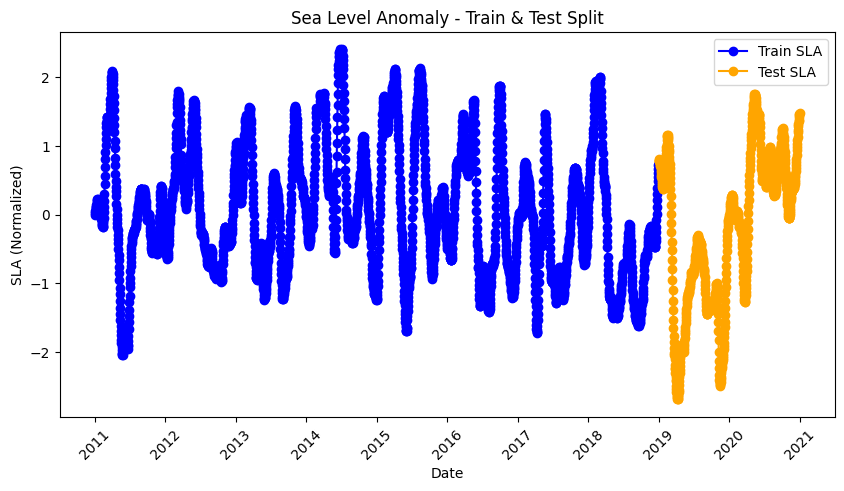

In [10]:
# Load CSV file
df = pd.read_csv("/content/drive/MyDrive/TimeSeries/aviso_sla_nio_11_20_87.875E_18.125N.csv", parse_dates=["Dates"])

# Normalize SLA data
df["SLA"] = (df["SLA"] - df["SLA"].mean()) / df["SLA"].std()

# Split into train (80%) and test (20%)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Convert to NumPy arrays
X_train = train_df["SLA"].values[:-1].reshape(-1, 1)
Y_train = train_df["SLA"].values[1:].reshape(-1, 1)

X_test = test_df["SLA"].values[:-1].reshape(-1, 1)
Y_test = test_df["SLA"].values[1:].reshape(-1, 1)

# Plot SLA time series
plt.figure(figsize=(10, 5))
plt.plot(train_df["Dates"], train_df["SLA"], label="Train SLA", marker="o", color="blue")
plt.plot(test_df["Dates"], test_df["SLA"], label="Test SLA", marker="o", color="orange")
plt.xlabel("Date")
plt.ylabel("SLA (Normalized)")
plt.title("Sea Level Anomaly - Train & Test Split")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [11]:
# Create a reservoir with 100 neurons
reservoir = Reservoir(200, lr=0.9, sr=1.2)  # lr: leaking rate, sr: spectral radius

# Readout layer using Ridge regression
readout = Ridge(ridge=1e-6)

# Train the LSM
reservoir_states = reservoir.run(X_train)
readout.fit(reservoir_states, Y_train)


Running Reservoir-2: 100%|██████████| 2921/2921 [00:00<00:00, 12855.77it/s]


'Ridge-2': Ridge(ridge=1e-06, input_bias=True, in=200, out=1)

Running Ridge-2: 100%|██████████| 730/730 [00:00<00:00, 68318.76it/s]


Mean Absolute Error (MAE): 0.0242
Root Mean Square Error (RMSE): 0.0481


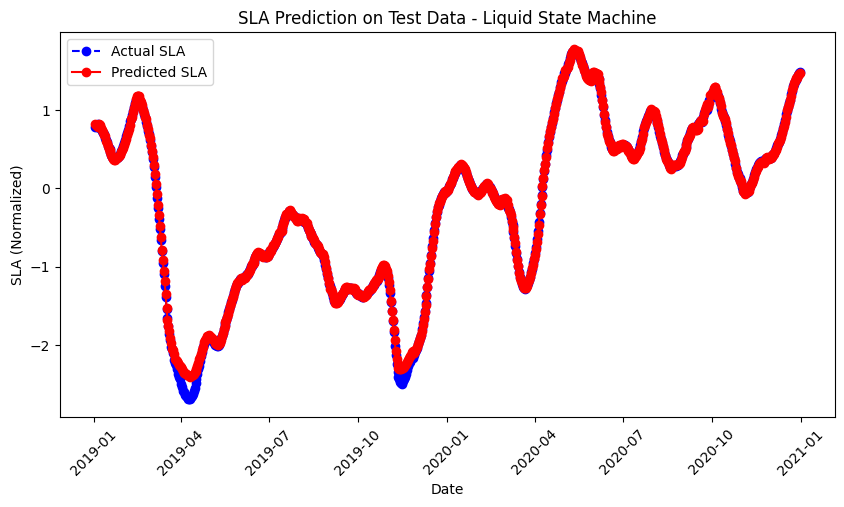

In [12]:
# Predict on test data
test_states = reservoir.run(X_test)
predicted_sla_test = readout.run(test_states)

# Calculate Error Metrics
mae = mean_absolute_error(Y_test, predicted_sla_test)
rmse = np.sqrt(mean_squared_error(Y_test, predicted_sla_test))

# Print Metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Plot actual vs predicted SLA for test data
plt.figure(figsize=(10, 5))
plt.plot(test_df["Dates"][1:], Y_test, label="Actual SLA", linestyle="dashed", marker="o", color="blue")
plt.plot(test_df["Dates"][1:], predicted_sla_test, label="Predicted SLA", marker="o", color="red")
plt.xlabel("Date")
plt.ylabel("SLA (Normalized)")
plt.title("SLA Prediction on Test Data - Liquid State Machine")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Running Ridge-2: 100%|██████████| 1/1 [00:00<00:00, 9868.95it/s]


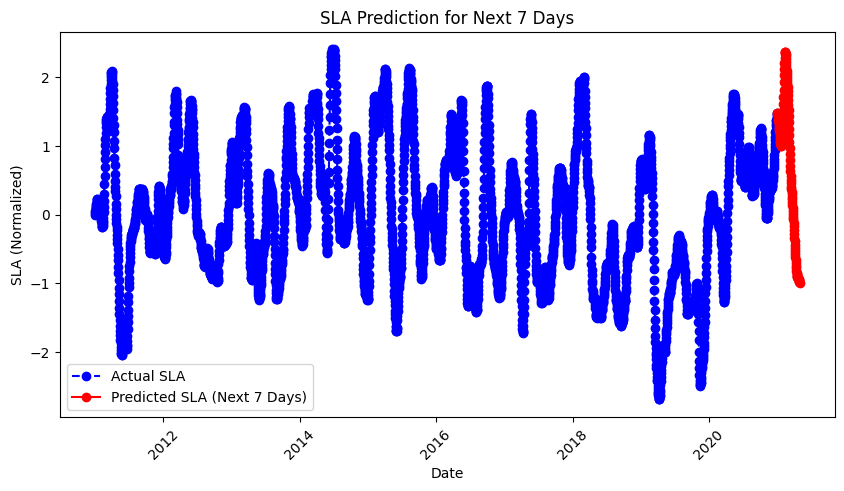

         Dates  Predicted_SLA
0   2021-01-01       1.483201
1   2021-01-02       1.477247
2   2021-01-03       1.466716
3   2021-01-04       1.449070
4   2021-01-05       1.426184
..         ...            ...
115 2021-04-26      -0.950600
116 2021-04-27      -0.960004
117 2021-04-28      -0.970372
118 2021-04-29      -0.981383
119 2021-04-30      -0.992607

[120 rows x 2 columns]


In [13]:
# Generate next 7 days of predictions
future_predictions = []
last_input = test_df["SLA"].values[-1].reshape(1, 1)

for _ in range(120):
    reservoir_state = reservoir.run(last_input)
    next_sla = readout.run(reservoir_state)
    future_predictions.append(next_sla.item())
    last_input = next_sla.reshape(1, 1)

# Create future dates
future_dates = pd.date_range(start=test_df["Dates"].iloc[-1] + pd.Timedelta(days=1), periods=120)

# Create prediction DataFrame
future_df = pd.DataFrame({"Dates": future_dates, "Predicted_SLA": future_predictions})

# Plot future predictions
plt.figure(figsize=(10, 5))
plt.plot(df["Dates"], df["SLA"], label="Actual SLA", linestyle="dashed", marker="o", color="blue")
plt.plot(future_df["Dates"], future_df["Predicted_SLA"], label="Predicted SLA (Next 7 Days)", marker="o", color="red")
plt.xlabel("Date")
plt.ylabel("SLA (Normalized)")
plt.title("SLA Prediction for Next 7 Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print future predictions
print(future_df)
